<a href="https://colab.research.google.com/github/E23A48/MachineLearning_LSTM/blob/main/TB2_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Integrantes:**

*   Camilo Silva
*   Piero Herrera



#### Librerías importadas

In [1]:
from IPython.core.debugger import set_trace
import pandas as pd #Nos permite cargar el dataset con la información a utilizar
import numpy as np #Manejo de numpy arrays
import os
import matplotlib.pyplot as plt  #Para graficar la tabla de validación
import time
from sklearn.metrics import mean_squared_error #Para medir el error cuadratico medio
from keras.models import Sequential
from keras.layers import LSTM, Dense, RNN, GRU, SimpleRNN
from sklearn.preprocessing import MinMaxScaler

plt.style.use(style="seaborn") #Estilo de plot 
%matplotlib inline

Se implementará la red LSTM para realizar la predicción del valor de acciones de una determinada compañía. 

#### Carga del dataset

El dataset usado contiene la información de los precios de las acciones de la compañía Microsoft desde agosto del 2019 hasta agosto del 2020. 

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/E23A48/test_datasets/main/MSFT-1Y-Hourly.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753 entries, 0 to 1752
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      1753 non-null   object 
 1   open      1753 non-null   float64
 2   high      1753 non-null   float64
 3   low       1753 non-null   float64
 4   close     1753 non-null   float64
 5   volume    1753 non-null   int64  
 6   average   1753 non-null   float64
 7   barCount  1753 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 109.7+ KB


Como podemos observar, los registros se hacen cada hora, desde que se abre el mercado hasta que se cierra.

In [3]:
df.set_index("date", drop=True, inplace=True)
df.head(5)

,open,high,low,close,volume,average,barCount
date,,,,,,,
2019-08-07 14:30:00,133.80,133.83,131.82,132.89,35647,132.701,17523
2019-08-07 15:00:00,132.87,135.20,132.64,134.75,48757,134.043,26974
2019-08-07 16:00:00,134.74,134.92,133.52,133.88,28977,134.147,17853
2019-08-07 17:00:00,133.89,134.06,133.07,133.90,21670,133.618,13497
2019-08-07 18:00:00,133.89,135.24,133.83,134.83,22648,134.653,12602


*   Open: Valor del stock al momento de abrir
*   Hight: Valor más alto del stock registrado dentro de la hora
*   Low: Valor más bajo del stock registrado dentro de la hora
*   Close: Valor del stock al momento de cerrar




Para esta implementación solo se hará uso del valo registrado al momento de cerrar el mercado.

In [4]:
df = df[["close"]]

In [5]:
type(df["close"]) == type(df[["close"]])

False

In [6]:
type(df[["close"]])

pandas.core.frame.DataFrame

DataSet con unicamente la columna **close**

In [7]:
df.describe()

,close
count,1753.000000
mean,164.330610
std,23.125225
min,132.670000
25%,143.320000
50%,159.750000
75%,183.390000
max,216.540000


Representación gráfica del valor de las acciones a lo largo de las horas y días:

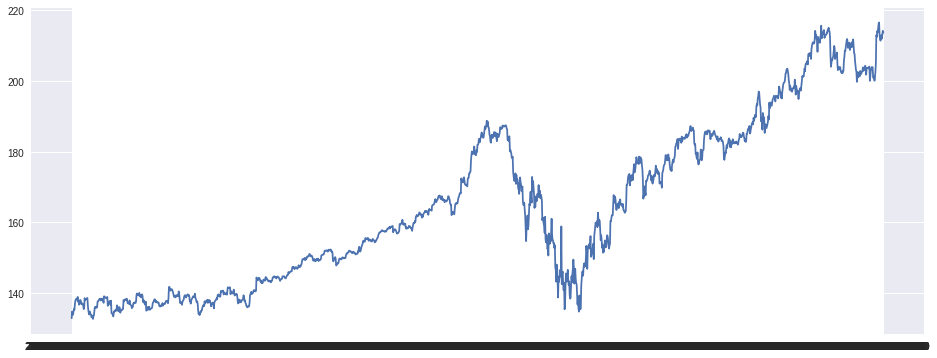

In [8]:
plt.figure(1, figsize=(16, 6))
_ = plt.plot(df.close)

#### **Calcular cambio porcentual:**

Se usa la función **pct_change** (cambio porcentual) en lugar de directamente el valor es la normalización. Esto nos permite medir todas las variables en una métrica comparable. Además, los retornos tienen propiedades estadísticas más flexibles que los precios, como la estacionariedad, ya que en la mayoría de los casos no tenemos precios estacionarios pero podemos tener retornos estacionarios.

* Una serie de tiempo estacionaria es aquella en la que las propiedades estadísticas como la media, la varianza, la correlación, etc., son constantes en el tiempo.

In [9]:
df["returns"] = df.close.pct_change()

In [10]:
df.head(5)

,close,returns
date,,
2019-08-07 14:30:00,132.89,NaN
2019-08-07 15:00:00,134.75,0.013997
2019-08-07 16:00:00,133.88,-0.006456
2019-08-07 17:00:00,133.90,0.000149
2019-08-07 18:00:00,134.83,0.006945


Calculo manual de representación

In [11]:
134.75 / 132.89 - 1

0.013996538490480992

#### **Calcular retornos logarítmicos**

Aparte de la normalización, los retornos logaritmicos tiene varias ventajas:

*   **Logaritmo de normalidad**
*   **Igualdad aproximada del registro bruto:**: Cuando los retornos son muy pequeños, la siguiente aproximación asegura que su valor sea cercano a los retornos brutos
*   **Aditividad en el tiempo**: Permite tener en cuenta el rendimiento acumulado a través del tiempo
*   **Facilidad matemática**: Cálculo simple
*   **Estabilidad numérica**: La suma de números pequeños es numéricamente segura, caso contrario en las multiplicaciones que generan desbordamiento aritmético.







In [12]:
df["log_returns"] = np.log(1 + df["returns"])

In [13]:
df.head(5)

,close,returns,log_returns
date,,,
2019-08-07 14:30:00,132.89,NaN,NaN
2019-08-07 15:00:00,134.75,0.013997,0.013899
2019-08-07 16:00:00,133.88,-0.006456,-0.006477
2019-08-07 17:00:00,133.90,0.000149,0.000149
2019-08-07 18:00:00,134.83,0.006945,0.006921


Visualización de **retornos logaritmicos** a traves del tiempo

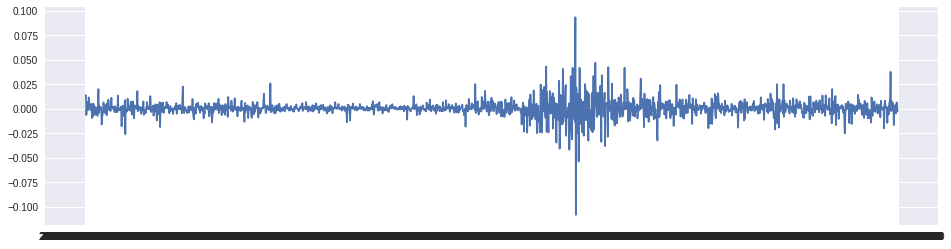

In [ ]:
plt.figure(1, figsize=(16, 4))
plt.plot(df.log_returns)

In [14]:
df.dropna(inplace=True)
X = df[["close", "log_returns"]].values

In [15]:
X

array([[ 1.34750000e+02,  1.38994914e-02],
       [ 1.33880000e+02, -6.47733345e-03],
       [ 1.33900000e+02,  1.49376354e-04],
       ...,
       [ 2.13350000e+02,  6.48925441e-03],
       [ 2.14190000e+02,  3.92946195e-03],
       [ 2.13640000e+02, -2.57111611e-03]])

#### **Transformación de las características a un rango determinado**



In [16]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = scaler.transform(X)

In [17]:
X_scaled[:5]

array([[0.02480029, 0.6063657 ],
       [0.01442709, 0.50534309],
       [0.01466555, 0.53819647],
       [0.02575414, 0.57177063],
       [0.03350423, 0.56129908]])

In [18]:
y = [x[0] for x in X_scaled]

In [19]:
y[:5]

[0.024800286157148133,
 0.014427089543340932,
 0.014665553833313805,
 0.025754143317038736,
 0.033504232741147]

#### **División del dataset**

In [20]:
split = int(len(X_scaled) * 0.8)
print(split)

1401


In [21]:
#División de la data de entrenamiento y test
X_train = X_scaled[:split]
X_test = X_scaled[split : len(X_scaled)]
y_train = y[:split]
y_test = y[split : len(y)]

In [22]:
#Verificación de longitud
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

#### **Etiquetado de registros**


Queremos predecir el precio de las acciones en el futuro. Predeciremos el precio de las acciones en el tiempo t + 1 en relación con el precio de las acciones en el tiempo t.

Ya que se va a usar la arquitectura LSTM, sabemos que tiene memoria y que se mantiene estableciendo las ***épocas***, básicamente cuántos pasos en el pasado queremos que use LSTM.

Las ***épocas*** se refiere a cuántos pasos en el tiempo queremos que utilice el algoritmo de retropropagación al calcular los gradientes para las actualizaciones de peso durante el entrenamiento.

Mencionado lo anterior, se debe usar un método para crear tanto el paso de tiempo como la variable de salida, el t + 1.

In [23]:
n = 3
Xtrain = []
ytrain = []
Xtest = []
ytest = []
for i in range(n, len(X_train)):
    Xtrain.append(X_train[i - n : i, : X_train.shape[1]])
    ytrain.append(y_train[i]) 
for i in range(n, len(X_test)):
    Xtest.append(X_test[i - n : i, : X_test.shape[1]])
    ytest.append(y_test[i])

In [24]:
Xtrain[0]

array([[0.02480029, 0.6063657 ],
       [0.01442709, 0.50534309],
       [0.01466555, 0.53819647]])

In [25]:
ytrain[0]

0.025754143317038736

En una red LSTM, la entrada para cada capa LSTM debe contener la siguiente información:
- El número de observaciones
- Las épocas
- Las características

Por lo tanto, necesitamos agregar una dimensión temporal en comparación con una red clásica:

(número de observaciones, número de épocas, número de características por paso)

In [26]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [27]:
print(Xtrain.shape)
print(ytrain.shape)
print("---")
print(Xtest.shape)
print(ytest.shape)

(1398, 3, 2)
(1398,)
---
(348, 3, 2)
(348,)


#### **LSTM Model**

In [37]:
model = Sequential()
model.add(LSTM(4, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
history = model.fit(
    Xtrain, ytrain, epochs=50, validation_data=(Xtest, ytest), batch_size=20, verbose=1
)

Epoch 1/50
70/70 [==============================] - 1s 7ms/step - loss: 0.1035 - val_loss: 0.6119
Epoch 2/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0631 - val_loss: 0.4192
Epoch 3/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.3198
Epoch 4/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.2269
Epoch 5/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.1553
Epoch 6/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0168 - val_loss: 0.0939
Epoch 7/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0425
Epoch 8/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0161
Epoch 9/50
70/70 [==============================] - 0s 2ms/step - loss: 6.5168e-04 - val_loss: 0.0081
Epoch 10/50
70/70 [==============================] - 0s 2ms/step - loss: 3.5606e-04 - val_loss: 0.0064
Epoch 11/50

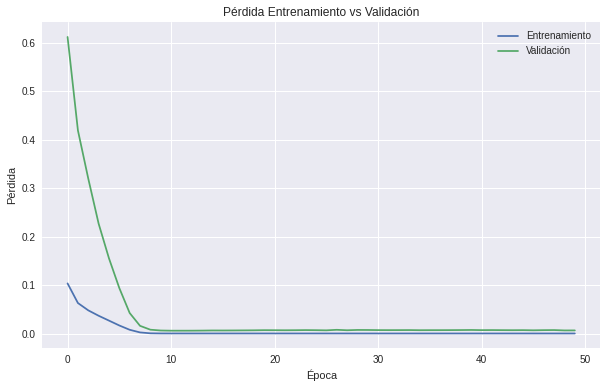

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida Entrenamiento vs Validación')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 112       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


##### Cálculo del error cuadrático medio

In [40]:
trainPredict = model.predict(Xtrain)
testPredict = model.predict(Xtest)

In [41]:
trainPredict = np.c_[trainPredict, np.zeros(trainPredict.shape)]
testPredict = np.c_[testPredict, np.zeros(testPredict.shape)]

In [42]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = [x[0] for x in trainPredict]

testPredict = scaler.inverse_transform(testPredict)
testPredict = [x[0] for x in testPredict]


In [43]:
print(trainPredict[:5])
print(testPredict[:5])

[134.93853069029745, 135.2427464269474, 135.57358518429098, 135.77011687919494, 136.5794354623556]
[183.04814123630524, 182.83203266978265, 182.574402064085, 181.862863484025, 179.37787491917612]


In [44]:
trainScore = mean_squared_error([x[0][0] for x in Xtrain], trainPredict, squared=False)
print("Train Score: %.10f RMSE" % (trainScore))

testScore = mean_squared_error([x[0][0] for x in Xtest], testPredict, squared=False)
print("Test Score: %.10f RMSE" % (testScore))

Train Score: 156.2497734915 RMSE
Test Score: 192.9400048986 RMSE


##### Predicción Gráfica

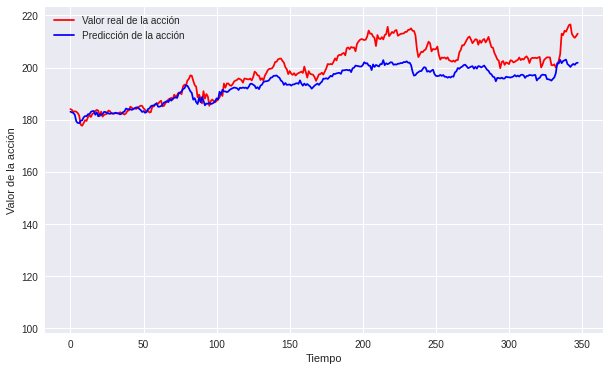

In [45]:
def graficar_predicciones(real, prediccion):
    plt.figure(figsize=(10, 6))
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

graficar_predicciones(list(df['close'][1400:]), testPredict)

##### Validación de entrenamiento

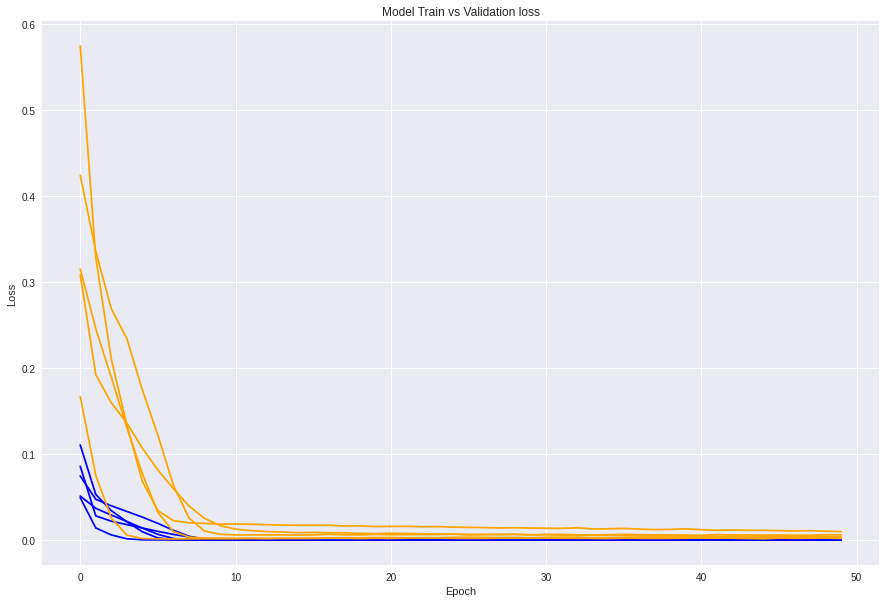

In [46]:
entreno = pd.DataFrame()
valida = pd.DataFrame()
for i in range(5):
  model = Sequential()
  model.add(LSTM(4, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
  model.add(Dense(1))
  model.compile(loss="mean_squared_error", optimizer="adam")
  history = model.fit(Xtrain, ytrain, epochs=50, validation_data=(Xtest, ytest), batch_size=20, verbose=0)
  entreno[str(i)] = history.history['loss']
  valida[str(i)] = history.history['val_loss']

plt.figure(figsize=(15, 10))
plt.plot(entreno, color='blue', label='Entrenamiento')
plt.plot(valida, color='orange', label='Validación')
plt.title('Model Train vs Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

##### Época óptima

In [59]:
results = []
for epoch in range(50, 200, 10):
  model = Sequential()
  model.add(LSTM(4, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
  model.add(Dense(1))
  model.compile(loss="mean_squared_error", optimizer="adam")
  history = model.fit(Xtrain, ytrain, epochs=epoch, validation_data=(Xtest, ytest), batch_size=20, verbose=0)
  trainPredict = model.predict(Xtrain)
  testPredict = model.predict(Xtest)
  results.append(mean_squared_error([x[0][0] for x in Xtest], testPredict, squared=False))

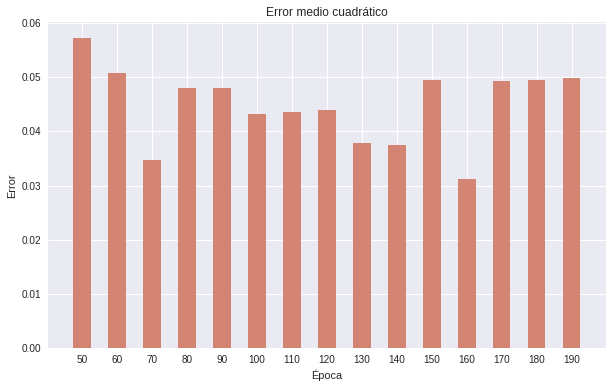

In [61]:
names = [i for i in range(50, 200, 10)]
plt.figure(figsize=(10, 6))
plt.bar(names, results, width=5, color = '#D48472')
plt.xticks(names, names)
plt.ylabel('Error')
plt.xlabel('Época')
plt.title('Error medio cuadrático')
plt.show()

Observamos que en la prueba realizada la época con menor error medio cuadrático es **160**. Conservaremos este valor para la siguiente optimización.

##### Batchsize óptimo

In [65]:
results = []
for batch_size in range(20, 100, 5):
  model = Sequential()
  model.add(LSTM(4, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
  model.add(Dense(1))
  model.compile(loss="mean_squared_error", optimizer="adam")
  history = model.fit(Xtrain, ytrain, epochs=160, validation_data=(Xtest, ytest), batch_size=batch_size, verbose=0)
  trainPredict = model.predict(Xtrain)
  testPredict = model.predict(Xtest)
  results.append(mean_squared_error([x[0][0] for x in Xtest], testPredict, squared=False))

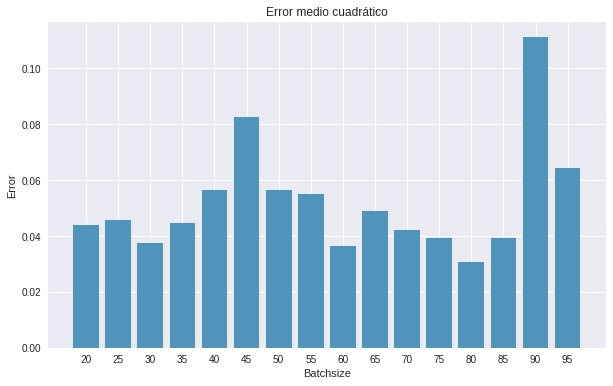

In [68]:
names = [i for i in range(20, 100, 5)]
plt.figure(figsize=(10, 6))
plt.bar(names, results, width=4, color = '#4F94BB')
plt.xticks(names, names)
plt.ylabel('Error')
plt.xlabel('Batchsize')
plt.title('Error medio cuadrático')
plt.show()

Observamos que en la prueba realizada el menor error medio cuadrático obtenido es cuando el valor del batchsize es igual a **80**. Conservaremos este valor para las comparaciones con las otras RNN.

#### **Comparación con otras RNN**

In [69]:
errors = {'LSTM': 0, 'GRU': 0, 'Simple-RNN': 0}

epochs = 160
batch_size = 80

# Red LSTM
model = Sequential()
model.add(LSTM(1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(Xtrain, ytrain, epochs=epochs, validation_data=(Xtest, ytest), batch_size=batch_size, verbose=0)
trainPredict = model.predict(Xtrain)
testPredict = model.predict(Xtest)
errors["LSTM"] = mean_squared_error([x[0][0] for x in Xtest], testPredict, squared=False)

# Red GRU
model = Sequential()
model.add(GRU(1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(Xtrain, ytrain, epochs=epochs, validation_data=(Xtest, ytest), batch_size=batch_size, verbose=0)
trainPredict = model.predict(Xtrain)
testPredict = model.predict(Xtest)
errors["GRU"] = mean_squared_error([x[0][0] for x in Xtest], testPredict, squared=False)

# Red RNN
model = Sequential()
model.add(SimpleRNN(1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(Xtrain, ytrain, epochs=epochs, validation_data=(Xtest, ytest), batch_size=batch_size, verbose=0)
trainPredict = model.predict(Xtrain)
testPredict = model.predict(Xtest)
errors["Simple-RNN"] = mean_squared_error([x[0][0] for x in Xtest], testPredict, squared=False)


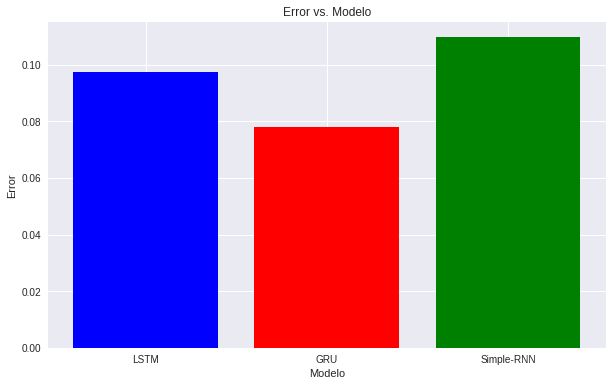

In [70]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(errors)), list(errors.values()), align='center', color=['blue', 'red', 'green'])
plt.xticks(range(len(errors)), list(errors.keys()))
plt.ylabel('Error')
plt.xlabel('Modelo')
plt.title('Error vs. Modelo')
plt.show()